In [2]:
import numpy as np # linear algebra
import pandas as pd 

In [3]:
import os
for dirname, _, filenames in os.walk('/Users/mac/Documents/Analysiss/covid19'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/Users/mac/Documents/Analysiss/covid19/.DS_Store
/Users/mac/Documents/Analysiss/covid19/Dissertation.ipynb
/Users/mac/Documents/Analysiss/covid19/covid_train.csv
/Users/mac/Documents/Analysiss/covid19/Pneumonia.csv
/Users/mac/Documents/Analysiss/covid19/pneumonia_train.csv
/Users/mac/Documents/Analysiss/covid19/test/.DS_Store
/Users/mac/Documents/Analysiss/covid19/test/Viral Pneumonia/0107.jpeg
/Users/mac/Documents/Analysiss/covid19/test/Viral Pneumonia/0111.jpeg
/Users/mac/Documents/Analysiss/covid19/test/Viral Pneumonia/0110.jpeg
/Users/mac/Documents/Analysiss/covid19/test/Viral Pneumonia/0106.jpeg
/Users/mac/Documents/Analysiss/covid19/test/Viral Pneumonia/0101.jpeg
/Users/mac/Documents/Analysiss/covid19/test/Viral Pneumonia/0117.jpeg
/Users/mac/Documents/Analysiss/covid19/test/Viral Pneumonia/0116.jpeg
/Users/mac/Documents/Analysiss/covid19/test/Viral Pneumonia/0120.jpeg
/Users/mac/Documents/Analysiss/covid19/test/Viral Pneumonia/0119.jpeg
/Users/mac/Documents/Analysiss/covid19/tes

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import filters, feature
from skimage.measure import shannon_entropy, moments, perimeter
import scipy.ndimage as ndi
import skimage.feature as feature
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from scipy.stats import skew, kurtosis
import cv2 as cv

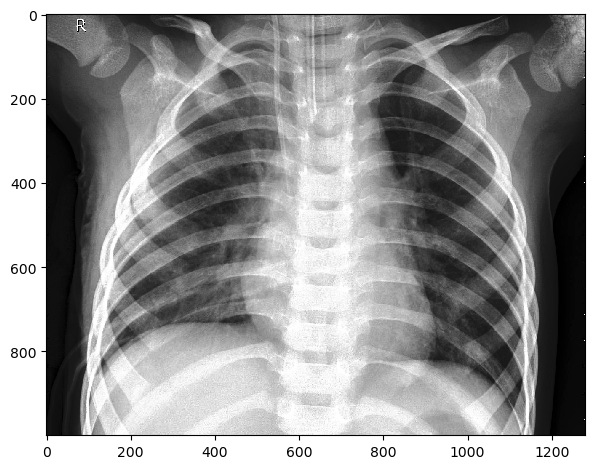

In [197]:
image1 = imread('/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/082.jpeg')
imshow(image1);

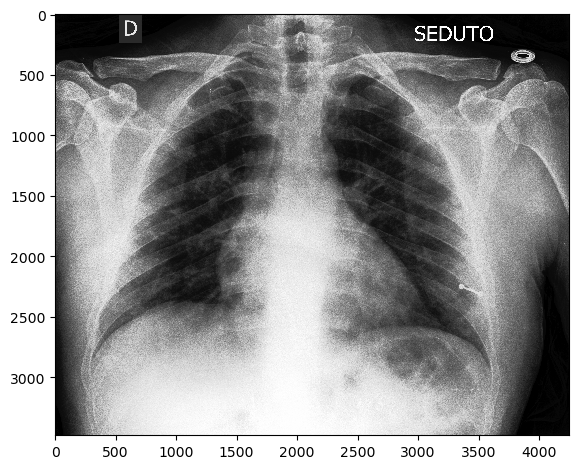

In [9]:
image2 = rgb2gray(imread('/Users/mac/Documents/Analysiss/Covid19/train/Covid/01.jpeg'))
imshow(image2);

In [10]:
print(image1.shape)
print(image2.shape)

(3480, 4248, 3)
(3480, 4248)


In [11]:
pixel_feat1 = np.reshape(image1, (3480*4248*3))
pixel_feat1, pixel_feat1.shape

(array([8, 8, 8, ..., 9, 9, 9], dtype=uint8), (44349120,))

In [12]:
pixel_feat2 = np.reshape(image2, (3480*4248))
pixel_feat2, pixel_feat2.shape

(array([0.03137255, 0.03137255, 0.03137255, ..., 0.03529412, 0.03529412,
        0.03529412]),
 (14783040,))

In [13]:
def edge_features(image2):
    # prewitt kernel
    pre_hor = filters.prewitt_h(image2)
    pre_ver = filters.prewitt_v(image2)

    # sobel kernel
    ed_sobel = filters.sobel(image2)

    # canny kernel
    can = feature.canny(image2)
    
    return pre_hor, pre_ver, ed_sobel, can

In [14]:
pre_hor = filters.prewitt_h(image2)
pre_ver = filters.prewitt_v(image2)

# sobel kernel
ed_sobel = filters.sobel(image2)

# canny kernel
can = feature.canny(image2)

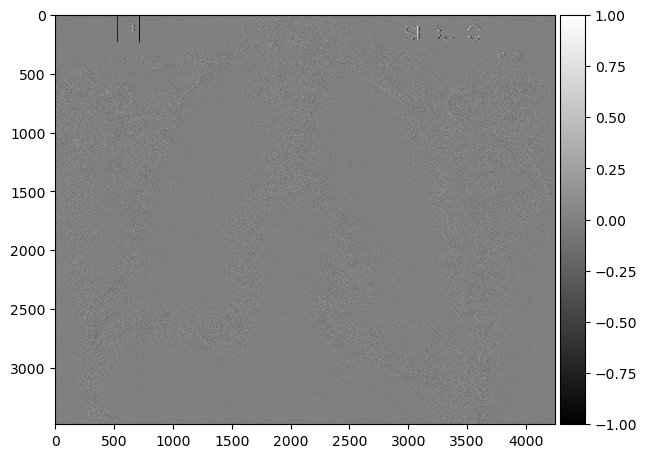

In [11]:
imshow(pre_ver, cmap='gray')

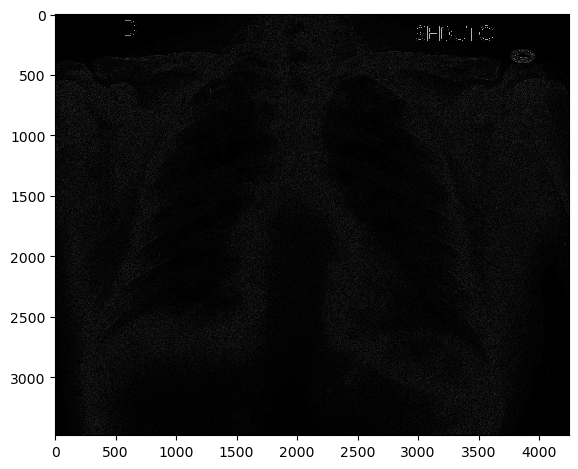

In [12]:
imshow(ed_sobel, cmap='gray');

In [15]:
def texture_features(image1):
    # img = cv.imread(image1)
    gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)

    # Find the GLCM

    graycom = feature.graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)

    # Find the GLCM properties
    contrast = feature.graycoprops(graycom, 'contrast')
    dissimilarity = feature.graycoprops(graycom, 'dissimilarity')
    homogeneity = feature.graycoprops(graycom, 'homogeneity')
    energy = feature.graycoprops(graycom, 'energy')
    correlation = feature.graycoprops(graycom, 'correlation')
    ASM = feature.graycoprops(graycom, 'ASM')
    
    glcm = np.squeeze(feature.graycomatrix(gray, distances=[1], 
                               angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, 
                               normed=True))

    entropy = -np.sum(glcm*np.log2(glcm + (glcm==0)))
    shannon = shannon_entropy(gray)
#     print('Entropy: {}'.format(entropy))

#     print("Contrast: {}".format(contrast))
#     print("Dissimilarity: {}".format(dissimilarity))
#     print("Homogeneity: {}".format(homogeneity))
#     print("Energy: {}".format(energy))
#     print("Correlation: {}".format(correlation))
#     print("ASM: {}".format(ASM))

    return contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy, shannon

In [16]:
gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
glcm = np.squeeze(feature.graycomatrix(gray, distances=[1], 
                               angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, 
                               normed=True))

entropy = -np.sum(glcm*np.log2(glcm + (glcm==0)))
print('Entropy: {}'.format(entropy))

Entropy: 51.87026621637094


In [17]:
def moments_features(image2):
    M = moments(image2)
#     print(M)
    area = M[0][0]
    cx = M[1, 0] / M[0, 0]
    cy = M[0, 1] / M[0, 0]
    centroid = (cx, cy)

#     print(area)
#     print(centroid)
    # eccentricity
    mu_20 = M[2, 0] / M[0, 0] - (cx ** 2)
    mu_02 = M[0, 2] / M[0, 0] - (cy ** 2)
    mu_11 = M[1, 1] / M[0, 0] - (cx * cy)

    e = (((mu_20 - mu_02) ** 2) + (4 * mu_11 ** 2)) / ((mu_20 + mu_02) ** 2)
#     print('Eccentricity = {}'.format(e))
    
    delta = np.sqrt(4 * mu_11 ** 2 + (mu_20 - mu_02) ** 2)

    lambda_1 = ((mu_20 + mu_02) + delta) / 2
    lambda_2 = ((mu_20 + mu_02) - delta) / 2

    major_length = np.sqrt(np.abs(lambda_1)) * 4
    minor_length = np.sqrt(np.abs(lambda_2)) * 4

#     print(major_length)
#     print(minor_length)

    return area, centroid, e, major_length, minor_length

In [18]:
M = moments(image2)
print(M)
area = M[0][0]
cx = M[1, 0] / M[0, 0]
cy = M[0, 1] / M[0, 0]
centroid = (cx, cy)

print(area)
print(centroid)

[[7.29451008e+06 1.46734070e+10 3.91167890e+13 1.17971229e+17]
 [1.43896465e+10 2.83673489e+13 7.35062631e+16 2.16079624e+20]
 [3.53862172e+13 6.89150282e+16 1.74140037e+20 4.99122149e+23]
 [9.61859595e+16 1.86013284e+20 4.62316487e+23 1.30205195e+27]]
7294510.082352938
(1972.6679829071418, 2011.5685351581278)


In [19]:
# eccentricity
mu_20 = M[2, 0] / M[0, 0] - (cx ** 2)
mu_02 = M[0, 2] / M[0, 0] - (cy ** 2)
mu_11 = M[1, 1] / M[0, 0] - (cx * cy)

e = (((mu_20 - mu_02) ** 2) + (4 * mu_11 ** 2)) / ((mu_20 + mu_02) ** 2)
print('Eccentricity = {}'.format(e))



delta = np.sqrt(4 * mu_11 ** 2 + (mu_20 - mu_02) ** 2)

lambda_1 = ((mu_20 + mu_02) + delta) / 2
lambda_2 = ((mu_20 + mu_02) - delta) / 2

major_length = np.sqrt(np.abs(lambda_1)) * 4
minor_length = np.sqrt(np.abs(lambda_2)) * 4

print(major_length)
print(minor_length)

Eccentricity = 0.029386764403464244
4618.109194790053
3883.940436932026


In [20]:
p = perimeter(image2)
print("Perimeter = {}".format(p))

Perimeter = 10612.010132059735


In [21]:
df = pd.DataFrame(columns = ['pixel_feat', 'pre_hor', 'pre_ver', 'ed_sobel', 'can', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM', 'entropy', 'shannon_entropy', 'area', 'centroid', 'eccentricity', 'major_length', 'minor_length', 'perimeter', 'mean', 'var', 'std', 'skewness', 'kurtosis', 'SNR'])
df


,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,correlation,...,eccentricity,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR


In [22]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [23]:
sk = skew(image2.reshape(-1))
k = kurtosis(image2.reshape(-1))

print("Skewness = {}".format(sk))
print("Kurtosis = {}".format(k))

Skewness = -0.009544772160986138
Kurtosis = -1.2133931051134217


In [52]:
for dirname, _, filenames in os.walk('/Users/mac/Documents/Analysiss/Covid19/train/Covid/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        if path[-2] == 'n':
              continue
        image1 = imread(path)
        if len(image1.shape) == 2:
            continue
        image2 = rgb2gray(imread(path))
        print(image2.reshape(-1))
        shape = image2.shape
        pixel_feat = np.reshape(image2, shape)
        pre_hor, pre_ver, ed_sobel, can = edge_features(image2)
        contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy, s_e = texture_features(image1)
        area, centroid, eccentricity, major_length, minor_length = moments_features(image2)
        SNR = signaltonoise(image2, axis = None)
        p = perimeter(image2)
        mean = np.mean(image2)
        var = ndi.variance(image2)
        std = ndi.standard_deviation(image2)
        s = skew(image2.reshape(-1))
        k = kurtosis(image2.reshape(-1))
        df.loc[len(df.index)] = [pixel_feat, pre_hor, pre_ver, ed_sobel, can, contrast, dissimilarity, homogeneity, energy, correlation,  ASM, entropy, s_e, area, centroid, eccentricity, major_length, minor_length, perimeter, mean, var, std, s, k, SNR]

/Users/mac/Documents/Analysiss/Covid19/train/Covid/COVID-00006.jpg
/Users/mac/Documents/Analysiss/Covid19/train/Covid/COVID-00012.jpg
/Users/mac/Documents/Analysiss/Covid19/train/Covid/06.jpeg
[0.10196078 0.10196078 0.09803922 ... 0.03921569 0.03921569 0.03921569]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/060.jpeg
[1.         0.99215686 0.35686275 ... 0.99607843 1.         1.        ]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/COVID-00007.jpg
/Users/mac/Documents/Analysiss/Covid19/train/Covid/021.jpeg
[0.00392157 0.00392157 0.00784314 ... 0.00784314 0.00784314 0.00784314]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/COVID-00011.jpg
/Users/mac/Documents/Analysiss/Covid19/train/Covid/COVID-00005.jpg
/Users/mac/Documents/Analysiss/Covid19/train/Covid/040.jpeg
[0.00392157 0.00392157 0.00392157 ... 0.13333333 0.14901961 0.15686275]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/015.jpg
[0. 0. 0. ... 0. 0. 0.]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/083.

/Users/mac/Documents/Analysiss/Covid19/train/Covid/COVID-00030.jpg
/Users/mac/Documents/Analysiss/Covid19/train/Covid/COVID-00024.jpg
/Users/mac/Documents/Analysiss/Covid19/train/Covid/078.jpeg
[1.         1.         1.         ... 0.22745098 0.22745098 0.22745098]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/COVID-00018.jpg
/Users/mac/Documents/Analysiss/Covid19/train/Covid/081.jpeg
[0.69411765 0.         0.         ... 0.04313725 0.04313725 0.61960784]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/020.jpg
[0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/039.jpeg
[0.00392157 0.00392157 0.         ... 0.35686275 0.34509804 0.34901961]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/042.jpeg
[0.00392157 0.00392157 0.00392157 ... 0.02352941 0.02352941 0.02352941]
/Users/mac/Documents/Analysiss/Covid19/train/Covid/08.jpeg
[1.         0.35294118 0.40784314 ... 0.51372549 0.51372549 0.52156863]
/Users/ma

In [53]:
df['mean'].nunique()

68

In [54]:
dt = df.copy()

In [65]:
dt['result'] = ['covid'] * len(dt)

In [68]:
dt.to_csv('covid_train.csv')

In [67]:
df.to_csv('covidtrain.csv')

In [39]:
dir_path = '/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 70


In [70]:
for dirname, _, filenames in os.walk('/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        if path[-2] == 'n':
              continue
        image1 = imread(path)
        if len(image1.shape) == 2:
            continue
        image2 = rgb2gray(imread(path))
        print(image2.reshape(-1))
        shape = image2.shape
        pixel_feat = np.reshape(image2, shape)
        pre_hor, pre_ver, ed_sobel, can = edge_features(image2)
        contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy, s_e = texture_features(image1)
        area, centroid, eccentricity, major_length, minor_length = moments_features(image2)
        SNR = signaltonoise(image2, axis = None)
        p = perimeter(image2)
        mean = np.mean(image2)
        var = ndi.variance(image2)
        std = ndi.standard_deviation(image2)
        s = skew(image2.reshape(-1))
        k = kurtosis(image2.reshape(-1))
        df.loc[len(df.index)] = [pixel_feat, pre_hor, pre_ver, ed_sobel, can, contrast, dissimilarity, homogeneity, energy, correlation,  ASM, entropy, s_e, area, centroid, eccentricity, major_length, minor_length, perimeter, mean, var, std, s, k, SNR]

/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/06.jpeg
[0.12156863 0.12156863 0.12156863 ... 0.09411765 0.09411765 0.09411765]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/037.jpeg
[0.16470588 0.16078431 0.15686275 ... 0.04313725 0.04313725 0.03529412]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/076.jpeg
[0.         0.         0.00392157 ... 0.         0.         0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/021.jpeg
[0.00784314 0.00784314 0.00784314 ... 0.00784314 0.00392157 0.00784314]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/056.jpeg
[0.         0.         0.         ... 0.01176471 0.05490196 0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/083.jpeg
[0.07843137 0.07843137 0.07843137 ... 0.         0.         0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/095.jpeg
[0.02352941 0.02745098 0.02745098 ... 0.         0.         0.        ]
/Users/

/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/043.jpeg
[0.03529412 0.03921569 0.04313725 ... 0.         0.         0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/038.jpeg
[0.40784314 0.40392157 0.40392157 ... 0.         0.         0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/096.jpeg
[0.21568627 0.21176471 0.20392157 ... 0.07058824 0.07058824 0.07058824]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/018.jpeg
[0.09803922 0.09803922 0.10196078 ... 0.         0.         0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/05.jpeg
[0.04313725 0.04705882 0.04313725 ... 0.         0.         0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/034.jpeg
[0. 0. 0. ... 0. 0. 0.]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneumonia/063.jpeg
[0.10980392 0.11372549 0.09803922 ... 0.         0.         0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/Viral Pneu

In [71]:
df

,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,correlation,...,eccentricity,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR
0,"[[0.12156862745098039, 0.12156862745098039, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.4532694666933983e-18, 2.4532694666933983e-...","[[False, False, False, False, False, False, Fa...","[[36.46495923323791, 66.31213812624404, 43.467...","[[3.6722972504119875, 5.034409607348086, 3.809...","[[0.3637363924343424, 0.30129425091579254, 0.3...","[[0.03275905313519533, 0.030588368675202173, 0...","[[0.9967404267610388, 0.9940701805161206, 0.99...",...,0.004693,1647.255762,1538.017858,<function perimeter at 0x7f7f34e9a1f0>,0.497437,0.086047,0.293337,0.006548,-1.209977,1.6957871306906498
1,"[[0.16470588235294117, 0.1607843137254902, 0.1...","[[0.0, 1.3877787807814457e-17, 1.3877787807814...","[[-0.0039215686274509665, -0.00784313725490197...","[[0.002772967769359, 0.005545935538718024, 0.0...","[[False, False, False, False, False, False, Fa...","[[34.96780560729829, 64.7427490510565, 42.7673...","[[3.561450953712642, 4.89405621617136, 3.61049...","[[0.32696615138907, 0.2542486247263497, 0.3351...","[[0.01992297438412014, 0.017253332596806215, 0...","[[0.9968007050401148, 0.9940745044665933, 0.99...",...,0.013956,1452.461887,1289.907881,<function perimeter at 0x7f7f34e9a1f0>,0.503422,0.084121,0.290037,-0.000583,-1.201185,1.7357181017742045
2,"[[0.0, 0.0, 0.00392156862745098, 0.00392156862...","[[0.0, 0.0, 0.00130718954248366, 0.00130718954...","[[0.0, 0.00392156862745098, 0.0052287581699346...","[[0.0, 0.0027729677693590095, 0.00353485419163...","[[False, False, False, False, False, False, Fa...","[[77.56139813131527, 127.37327491272178, 79.29...","[[3.2040272753078707, 4.502109899179886, 3.379...","[[0.4130501952664368, 0.35122115957289296, 0.4...","[[0.14023079581126935, 0.13976967261632361, 0....","[[0.9942107885588777, 0.9904908185101292, 0.99...",...,0.026688,1247.883422,1058.239192,<function perimeter at 0x7f7f34e9a1f0>,0.431865,0.103074,0.321052,0.125209,-1.303633,1.3451571950964614
3,"[[0.00784313725490196, 0.00784313725490196, 0....","[[-8.673617379884035e-19, -8.673617379884035e-...","[[0.0, 0.0, 0.00392156862745098, 0.00392156862...","[[0.0, 0.0, 0.0027729677693590095, 0.002772967...","[[False, False, False, False, False, False, Fa...","[[70.87353651869444, 111.47434713502167, 71.24...","[[2.5277255566386576, 3.5411995278760156, 2.64...","[[0.452728242222631, 0.37496644839619125, 0.44...","[[0.09679160260659453, 0.09607162287487774, 0....","[[0.9944160602029398, 0.9912158603856068, 0.99...",...,0.004553,1302.926335,1217.785789,<function perimeter at 0x7f7f34e9a1f0>,0.453818,0.097668,0.312518,0.064650,-1.266573,1.4521316718436683
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[False, False, False, False, False, False, Fa...","[[88.15136308254738, 134.7733806702899, 85.434...","[[2.3608818154127365, 3.4130056341821957, 2.58...","[[0.490707270696113, 0.4117263632583624, 0.470...","[[0.15680665610473157, 0.15634800792643833, 0....","[[0.9935050642754264, 0.990062822832262, 0.993...",...,0.002522,1099.610309,1045.709141,<function perimeter at 0x7f7f34e9a1f0>,0.422759,0.104415,0.323134,0.155829,-1.308979,1.3083107650344281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,"[[0.04313725490196079, 0.047058823529411764, 0...","[[0.001307189542483659, 0.001307189542483659, ...","[[0.005228758169934636, 0.0, -0.00392156862745...","[[0.003534854191631359, 0.0013864838846795037,...","[[False, False, False, False, False, False, Fa...","[[59.348568045191705, 101.65949815759747, 63.9...","[[3.8578564512269264, 5.333280486156606, 4.088...","[[0.31019792085334896, 0.24717725534162446, 0

In [72]:
df['mean'].nunique()

69

In [74]:
dy['result'] = ['pneumonia'] * len(dy)

In [73]:
dy = df.copy()

In [76]:
dy.to_csv('pneumonia_train.csv')

In [47]:
df.to_csv('Pneumonia.csv')

In [24]:
for dirname, _, filenames in os.walk('/Users/mac/Documents/Analysiss/Covid19/train/normal/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        if path[-2] == 'n':
              continue
        image1 = imread(path)
        if len(image1.shape) == 2:
            continue
        image2 = rgb2gray(imread(path))
        print(image2.reshape(-1))
        shape = image2.shape
        pixel_feat = np.reshape(image2, shape)
        pre_hor, pre_ver, ed_sobel, can = edge_features(image2)
        contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy, s_e = texture_features(image1)
        area, centroid, eccentricity, major_length, minor_length = moments_features(image2)
        SNR = signaltonoise(image2, axis = None)
        p = perimeter(image2)
        mean = np.mean(image2)
        var = ndi.variance(image2)
        std = ndi.standard_deviation(image2)
        s = skew(image2.reshape(-1))
        k = kurtosis(image2.reshape(-1))
        df.loc[len(df.index)] = [pixel_feat, pre_hor, pre_ver, ed_sobel, can, contrast, dissimilarity, homogeneity, energy, correlation,  ASM, entropy, s_e, area, centroid, eccentricity, major_length, minor_length, perimeter, mean, var, std, s, k, SNR]

/Users/mac/Documents/Analysiss/Covid19/train/normal/06.jpeg
[0.         0.06666667 0.08235294 ... 0.11372549 0.12941176 0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/normal/060.jpeg
[0.         0.06666667 0.05882353 ... 0.10588235 0.10588235 0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/normal/076.jpeg
[0.04313725 0.04313725 0.04313725 ... 0.04313725 0.04313725 0.04313725]
/Users/mac/Documents/Analysiss/Covid19/train/normal/021.jpeg
[0.         0.01568627 0.02352941 ... 0.01960784 0.01960784 0.01176471]
/Users/mac/Documents/Analysiss/Covid19/train/normal/056.jpeg
[0.         0.         0.         ... 0.08235294 0.07843137 0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/normal/017.jpeg
[0.00392157 0.04313725 0.0627451  ... 0.0627451  0.05490196 0.01568627]
/Users/mac/Documents/Analysiss/Covid19/train/normal/083.jpeg
[0.18431373 0.18431373 0.18823529 ... 0.         0.         0.        ]
/Users/mac/Documents/Analysiss/Covid19/train/normal/095.jpeg
[0.003921

/Users/mac/Documents/Analysiss/Covid19/train/normal/022.jpeg
[0.         0.01960784 0.05098039 ... 0.0627451  0.05882353 0.        ]


In [25]:
df

,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,correlation,...,eccentricity,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR
0,"[[0.0, 0.06666666666666667, 0.0823529411764705...","[[0.0, -0.005228758169934643, -0.0130718954248...","[[0.06666666666666665, 0.07712418300653595, 0....","[[0.04714045207910317, 0.05552863630786783, 0....","[[False, False, False, False, False, False, Fa...","[[53.240082818474114, 78.54059564257213, 41.59...","[[4.903297618414591, 6.295056827869728, 4.5490...","[[0.22999048651196433, 0.17665296552513857, 0....","[[0.015491134171953948, 0.013448181929143217, ...","[[0.9950816333490304, 0.9927422094091152, 0.99...",...,0.006117,2709.137016,2504.921855,<function perimeter at 0x7fbf4170aaf0>,0.502636,0.083303,0.288623,-0.001304,-1.200692,1.7414944399543297
1,"[[0.0, 0.06666666666666667, 0.0588235294117647...","[[0.0, 0.0, 0.0, -0.0013071895424836694, -0.00...","[[0.06666666666666665, 0.058823529411764705, 0...","[[0.04714045207910317, 0.041594516540385144, 2...","[[False, False, False, False, False, False, Fa...","[[45.14785306448013, 68.23272780836474, 35.032...","[[4.204952855115412, 5.581259277071447, 4.1738...","[[0.2748281473490242, 0.21606159601443412, 0.2...","[[0.018689736616781652, 0.01606841195594355, 0...","[[0.9958369872824503, 0.9937061032459433, 0.99...",...,0.003987,2001.274952,1878.652261,<function perimeter at 0x7fbf4170aaf0>,0.502362,0.083477,0.288925,-0.004418,-1.201193,1.7387308515131386
2,"[[0.04313725490196079, 0.04313725490196079, 0....","[[3.469446951953614e-18, 3.469446951953614e-18...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.2266347333466992e-18, 1.2266347333466992e-...","[[False, False, False, False, False, False, Fa...","[[44.98310802152743, 74.91289629057584, 51.017...","[[3.797397488467503, 5.296650360345012, 4.2152...","[[0.3057426782186672, 0.23635271159362115, 0.2...","[[0.024511996171037893, 0.022255693948352428, ...","[[0.9958810491600757, 0.993137353999415, 0.995...",...,0.013122,2081.350306,1855.144449,<function perimeter at 0x7fbf4170aaf0>,0.502571,0.084011,0.289847,-0.004170,-1.205755,1.733919196326065
3,"[[0.0, 0.01568627450980392, 0.0235294117647058...","[[0.0, 0.0, -1.734723475976807e-18, -8.6736173...","[[0.01568627450980392, 0.023529411764705882, 0...","[[0.011091871077436038, 0.016637806616154056, ...","[[False, False, False, False, False, False, Fa...","[[51.82848317817271, 83.41928892985004, 50.279...","[[4.809245555531445, 6.410862915016064, 4.9564...","[[0.2472495238215148, 0.19737052030178215, 0.2...","[[0.02099960587460849, 0.01910762166429364, 0....","[[0.9953360491568416, 0.99249025600601, 0.9954...",...,0.026507,2421.818788,2054.939244,<function perimeter at 0x7fbf4170aaf0>,0.496976,0.085517,0.292433,-0.003009,-1.201226,1.699452205765375
4,"[[0.0, 0.0, 0.0, 0.011764705882352941, 0.01568...","[[0.0, 0.0, 0.0, 8.673617379884035e-19, 2.1684...","[[0.0, 0.0, 0.011764705882352941, 0.0156862745...","[[0.0, 0.0, 0.008318903308077028, 0.0110918710...","[[False, False, False, False, False, False, Fa...","[[34.14295817034919, 53.655764254134844, 30.21...","[[3.403579533314397, 4.656505396477622, 3.5938...","[[0.33261234907053816, 0.26673979670064346, 0....","[[0.03205502729283494, 0.029775374315458496, 0...","[[0.9969139351188854, 0.99514889314593, 0.9972...",...,0.010370,2170.419801,1959.583019,<function perimeter at 0x7fbf4170aaf0>,0.497361,0.085149,0.291804,0.002675,-1.205601,1.7044386797616706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,"[[0.0, 0.0, 0.0, 0.10196078431372549, 0.098039...","[[0.0, 0.0, 0.0, 6.938893903907228e-18, 0.0, 6...","[[0.0, 0.0, 0.10196078431372549, 0.09803921568...","[[0.0, 0.0, 0.07209716200333426, 0.06932419423...","[[False, False, False, False, False, False, Fa...","[[47.7760303937099, 70.91287976908629, 38.4666...","[[4.40997227163395, 5.6906413055545775, 4.2020...","[[0.277711575822932, 0.225809568551872, 0.28

In [26]:
dg = df.copy()

In [27]:
dg['result'] = ['normal'] * len(dg)

In [29]:
dg.to_csv('normal_train.csv')

In [30]:
covid = pd.read_csv('covid_train.csv')

In [31]:
covid

,Unnamed: 0,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,...,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR,result
0,0,[[0.10196078 0.10196078 0.09803922 ... 0.03921...,[[-1.38777878e-17 6.93889390e-18 -1.30718954e...,[[ 0. -0.00392157 -0.00130719 ... 0. ...,[[4.90653893e-18 2.77296777e-03 9.80392157e-04...,[[False False False ... False False False]\n [...,[[27.79205051 41.84900264 25.49895576 41.46855...,[[2.93177653 3.69633708 2.8737189 3.64401996]],[[0.40950284 0.35710023 0.41296671 0.36222108]],[[0.03441274 0.03218863 0.03451194 0.03252628]],...,2873.431571,2412.026639,<function perimeter at 0x7f7f34e9a1f0>,0.502558,0.083824,0.289523,0.011939,-1.218634,1.735814,covid
1,1,[[1. 0.99215686 0.35686275 ... 0.08627...,[[-0.00261438 -0.01568627 -0.02745098 ... -0.0...,[[-0.00653595 -0.65620915 -0.64052288 ... -0.0...,[[0.00527957 0.46177407 0.45115299 ... 0.03211...,[[False False False ... False False False]\n [...,[[56.71140405 73.54581767 17.72666746 73.38945...,[[1.64941145 2.4469589 1.51929687 2.43816115]],[[0.56415105 0.45276706 0.57425415 0.45300648]],[[0.0336735 0.02785535 0.0340129 0.02784659]],...,1808.262470,1687.809750,<function perimeter at 0x7f7f34e9a1f0>,0.503216,0.084808,0.291219,-0.002207,-1.200499,1.727966,covid
2,2,[[0.00392157 0.00392157 0.00784314 ... 0.00392...,[[ 1.30718954e-03 2.61437908e-03 1.30718954e...,[[ 0.00130719 0.00522876 0.00522876 ... 0.0...,[[0.00098039 0.00404226 0.00438445 ... 0.00392...,[[False False False ... False False False]\n [...,[[38.66231487 53.15751071 27.98754086 53.98730...,[[3.99872133 4.47892992 3.28721005 4.50557768]],[[0.25871197 0.23872458 0.29969494 0.23824593]],[[0.01869159 0.01761485 0.02012548 0.01759816]],...,1969.721485,1573.843719,<function perimeter at 0x7f7f34e9a1f0>,0.500506,0.084451,0.290604,0.000692,-1.194595,1.722295,covid
3,3,[[0.00392157 0.00392157 0.00392157 ... 0. ...,[[-4.33680869e-19 -4.33680869e-19 -4.33680869e...,[[0. 0. 0. ... 0. ...,[[0. 0. 0. ... 0. ...,[[False False False ... False False False]\n [...,[[15.35705711 28.0884113 16.29733653 28.12075...,[[2.36521684 3.26017606 2.49031748 3.27674228]],[[0.37604578 0.29939884 0.36112407 0.29865188]],[[0.02839421 0.02536566 0.02753813 0.02526718]],...,2072.221373,1973.346886,<function perimeter at 0x7f7f34e9a1f0>,0.502345,0.084263,0.290281,0.002830,-1.196855,1.730549,covid
4,4,[[0. 0. 0. ... 0. ...,[[ 0. 0. 0. ... 0. ...,[[ 0. 0. 0. ... 0. ...,[[0. 0. 0. ... 0. ...,[[False False False ... False False False]\n [...,[[ 7.93396542 22.20597062 15.80821233 22.45925...,[[1.16208395 1.55809837 1.10290503 1.55916136]],[[0.57038025 0.49933896 0.59440535 0.49958286]],[[0.07234574 0.07020162 0.0731349 0.07021974]],...,3236.532239,3022.752259,<function perimeter at 0x7f7f34e9a1f0>,0.449705,0.045080,0.212321,-0.430528,-0.398814,2.118045,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,[[0.00392157 0.00392157 0.00392157 ... 0.00392...,[[-4.33680869e-19 -4.33680869e-19 -4.33680869e...,[[ 0. 0. 0. ... 0. ...,[[0. 0. 0. ... 0. ...,[[False False False ... False False False]\n [...,[[35.13696182 59.18461099 36.44546117 58.42852...,[[3.44533154 4.5710926 3.52365511 4.57584561]],[[0.32113762 0.26878624 0.31587335 0.26790314]],[[0.04920584 0.04745746 0.04802415 0.04733587]],...,1909.797255,1592.189541,<function perimeter at 0x7f7f34e9a1f0>,0.505223,0.087714,0.296165,0.056228,-1.139006,1.705884,covid
64,64,[[0.02745098 0.01960784 0.01568627 ... 0.00392...,[[-2.61437908e-03 0.00000000e+00 1.30718954e...,[[-0.00653595 -0.00915033 0. ... 0. ...,[[0.00527957 0.00693242 0.00138648 ... 0. ...,[[False False False ... False False False]\n [...,[[11.49339747 22.64352551 13.95716414 23.23225...,[[1.82905965 2.63825063 1.97870332 2.67991801]],[[0.48132932 0.39273129 0.47309459 0.38998336]],[[0.0288887 0.02468706 0.02823953 0.02453932]],...,1726.788489,1339.046626,<function perimeter at 0x7f7f34e9a1f0>,0.504870,0.082351,0.286969,-0.0

In [32]:
pneumo = pd.read_csv('pneumonia_train.csv')

In [33]:
normal = pd.read_csv('normal_train.csv')

In [35]:
len(normal)

70

In [38]:
coviddata = pd.concat([covid, normal, pneumo], keys='result')

In [45]:
coviddata[coviddata.columns[0]]

r  0      0
   1      1
   2      2
   3      3
   4      4
         ..
s  65    65
   66    66
   67    67
   68    68
   69    69
Name: Unnamed: 0, Length: 208, dtype: int64

In [56]:
dt = coviddata.copy()

In [60]:
dt.drop('Unnamed: 0', axis=1, inplace=True)

In [61]:
dt

pixel_feat  \
r 0   [[0.10196078 0.10196078 0.09803922 ... 0.03921...   
  1   [[1.         0.99215686 0.35686275 ... 0.08627...   
  2   [[0.00392157 0.00392157 0.00784314 ... 0.00392...   
  3   [[0.00392157 0.00392157 0.00392157 ... 0.     ...   
  4   [[0.         0.         0.         ... 0.     ...   
...                                                 ...   
s 65  [[0.04313725 0.04705882 0.04313725 ... 0.09803...   
  66  [[0.         0.         0.         ... 0.02352...   
  67  [[0.10980392 0.11372549 0.09803922 ... 0.06274...   
  68  [[0.0745098  0.07843137 0.08235294 ... 0.07058...   
  69  [[0.         0.         0.         ... 0.14901...   

                                                pre_hor  \
r 0   [[-1.38777878e-17  6.93889390e-18 -1.30718954e...   
  1   [[-0.00261438 -0.01568627 -0.02745098 ... -0.0...   
  2   [[ 1.30718954e-03  2.61437908e-03  1.30718954e...   
  3   [[-4.33680869e-19 -4.33680869e-19 -4.33680869e...   
  4   [[ 0.          0.          0.         ...  0. ...   
...                                                 ...   
s 65  [[ 0.00130719  0.00130719  0.00261438 ... -0.0...   
  66  [[ 0.          0.          0.         ...  0. ...   
  67  [[-5.22875817e-03 -5.22875817e-03 -3.92156863e...   
  68  [[-3.46944695e-18 -6.93889390e-18  0.00000000e...   
  69  [[ 0.          0.          0.         ... -0.0...   

                                                pre_ver  \
r 0   [[ 0.         -0.00392157 -0.00130719 ...  0. ...   
  1   [[-0.00653595 -0.65620915 -0.64052288 ... -0.0...   
  2   [[ 0.00130719  0.00522876  0.00522876 ...  0.0...   
  3   [[0.         0.         0.         ... 0.     ...   
  4   [[ 0.          0.          0.         ...  0. ...   
...                                                 ...   
s 65  [[ 5.22875817e-03  0.00000000e+00 -3.92156863e...   
  66  [[ 0.00000000e+00  0.00000000e+00  0.00000000e...   
  67  [[ 0.00261438 -0.01176471 -0.03660131 ...  0.0...   
  68  [[ 0.00392157  0.00784314  0.00784314 ... -0.0...   
  69  [[ 0.00000000e+00  0.00000000e+00  3.92156863e...   

                                               ed_sobel  \
r 0   [[4.90653893e-18 2.77296777e-03 9.80392157e-04...   
  1   [[0.00527957 0.46177407 0.45115299 ... 0.03211...   
  2   [[0.00098039 0.00404226 0.00438445 ... 0.00392...   
  3   [[0.         0.         0.         ... 0.     ...   
  4   [[0.         0.         0.         ... 0.     ...   
...                                                 ...   
s 65  [[0.00353485 0.00138648 0.00310027 ... 0.00392...   
  66  [[0.         0.         0.         ... 0.00438...   
  67  [[0.00404226 0.00930082 0.02648874 ... 0.01737...   
  68  [[0.00277297 0.00554594 0.00554594 ... 0.00924...   
  69  [[0.         0.         0.00277297 ... 0.01289...   

                                                    can  \
r 0   [[False False False ... False False False]\n [...   
  1   [[False False False ... False False False]\n [...   
  2   [[False False False ... False False False]\n [...   
  3   [[False False False ... False False False]\n [...   
  4   [[False False False ... False False False]\n [...   
...                                                 ...   
s 65  [[False False False ... False False False]\n [...   
  66  [[False False False ... False False False]\n [...   
  67  [[False False False ... False False False]\n [...   
  68  [[False False False ... False False False]\n [...   
  69  [[False False False ... False False False]\n [...   

                                               contrast  \
r 0   [[27.79205051 41.84900264 25.49895576 41.46855...   
  1   [[56.71140405 73.54581767 17.72666746 73.38945...   
  2   [[38.66231487 53.15751071 27.98754086 53.98730...   
  3   [[15.35705711 28.0884113  16.29733653 28.12075...   
  4   [[ 7.93396542 22.20597062 15.80821233 22.45925...   
...                                                 ...   
s 65  [[ 59.34856805 101.65949816  63.94992082  99.9...   
  66  [[ 71.67457607 112.851

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [73]:
result = pd.get_dummies(dt['result'])

In [75]:
dt.drop('result', axis=1, inplace=True)

In [77]:
dt = pd.concat([dt, result], axis=1)

In [104]:
dt

pixel_feat  \
r 0   [[0.10196078 0.10196078 0.09803922 ... 0.03921...   
  1   [[1.         0.99215686 0.35686275 ... 0.08627...   
  2   [[0.00392157 0.00392157 0.00784314 ... 0.00392...   
  3   [[0.00392157 0.00392157 0.00392157 ... 0.     ...   
  4   [[0.         0.         0.         ... 0.     ...   
...                                                 ...   
s 65  [[0.04313725 0.04705882 0.04313725 ... 0.09803...   
  66  [[0.         0.         0.         ... 0.02352...   
  67  [[0.10980392 0.11372549 0.09803922 ... 0.06274...   
  68  [[0.0745098  0.07843137 0.08235294 ... 0.07058...   
  69  [[0.         0.         0.         ... 0.14901...   

                                                pre_hor  \
r 0   [[-1.38777878e-17  6.93889390e-18 -1.30718954e...   
  1   [[-0.00261438 -0.01568627 -0.02745098 ... -0.0...   
  2   [[ 1.30718954e-03  2.61437908e-03  1.30718954e...   
  3   [[-4.33680869e-19 -4.33680869e-19 -4.33680869e...   
  4   [[ 0.          0.          0.         ...  0. ...   
...                                                 ...   
s 65  [[ 0.00130719  0.00130719  0.00261438 ... -0.0...   
  66  [[ 0.          0.          0.         ...  0. ...   
  67  [[-5.22875817e-03 -5.22875817e-03 -3.92156863e...   
  68  [[-3.46944695e-18 -6.93889390e-18  0.00000000e...   
  69  [[ 0.          0.          0.         ... -0.0...   

                                                pre_ver  \
r 0   [[ 0.         -0.00392157 -0.00130719 ...  0. ...   
  1   [[-0.00653595 -0.65620915 -0.64052288 ... -0.0...   
  2   [[ 0.00130719  0.00522876  0.00522876 ...  0.0...   
  3   [[0.         0.         0.         ... 0.     ...   
  4   [[ 0.          0.          0.         ...  0. ...   
...                                                 ...   
s 65  [[ 5.22875817e-03  0.00000000e+00 -3.92156863e...   
  66  [[ 0.00000000e+00  0.00000000e+00  0.00000000e...   
  67  [[ 0.00261438 -0.01176471 -0.03660131 ...  0.0...   
  68  [[ 0.00392157  0.00784314  0.00784314 ... -0.0...   
  69  [[ 0.00000000e+00  0.00000000e+00  3.92156863e...   

                                               ed_sobel  \
r 0   [[4.90653893e-18 2.77296777e-03 9.80392157e-04...   
  1   [[0.00527957 0.46177407 0.45115299 ... 0.03211...   
  2   [[0.00098039 0.00404226 0.00438445 ... 0.00392...   
  3   [[0.         0.         0.         ... 0.     ...   
  4   [[0.         0.         0.         ... 0.     ...   
...                                                 ...   
s 65  [[0.00353485 0.00138648 0.00310027 ... 0.00392...   
  66  [[0.         0.         0.         ... 0.00438...   
  67  [[0.00404226 0.00930082 0.02648874 ... 0.01737...   
  68  [[0.00277297 0.00554594 0.00554594 ... 0.00924...   
  69  [[0.         0.         0.00277297 ... 0.01289...   

                                                    can  \
r 0   [[False False False ... False False False]\n [...   
  1   [[False False False ... False False False]\n [...   
  2   [[False False False ... False False False]\n [...   
  3   [[False False False ... False False False]\n [...   
  4   [[False False False ... False False False]\n [...   
...                                                 ...   
s 65  [[False False False ... False False False]\n [...   
  66  [[False False False ... False False False]\n [...   
  67  [[False False False ... False False False]\n [...   
  68  [[False False False ... False False False]\n [...   
  69  [[False False False ... False False False]\n [...   

                                               contrast  \
r 0   [[27.79205051 41.84900264 25.49895576 41.46855...   
  1   [[56.71140405 73.54581767 17.72666746 73.38945...   
  2   [[38.66231487 53.15751071 27.98754086 53.98730...   
  3   [[15.35705711 28.0884113  16.29733653 28.12075...   
  4   [[ 7.93396542 22.20597062 15.80821233 22.45925...   
...                                                 ...   
s 65  [[ 59.34856805 101.65949816  63.94992082  99.9...   
  66  [[ 71.67457607 112.851

In [125]:
dt = coviddata.copy()

In [129]:
for column_name in dt.columns:
    if dt[column_name].dtype == object:
        dt[column_name] = le.fit_transform(dt[column_name])
    else:
        pass

In [126]:
dt.drop('Unnamed: 0', axis=1, inplace=True)

In [127]:
dt['result'].replace(['covid', 'normal', 'pneumonia'],
                        [0, 1, 2], inplace=True)

In [130]:
dt

pixel_feat  pre_hor  pre_ver  ed_sobel  can  contrast  dissimilarity  \
r 0          135      127       37       173   54       114             98   
  1          179      106      140        89   28       194             21   
  2           71       76       62        61   54       149            153   
  3           63      157      160        11   61        75             62   
  4            1        0        1         3   61        21              4   
...          ...      ...      ...       ...  ...       ...            ...   
s 65         118       58      120        80   61         1            149   
  66          15        5       49        18   61        23             56   
  67         138      166       67        83   61        59            136   
  68         127      150       72        71   14       164            158   
  69          22        9       53        44   61        15             79   

      homogeneity  energy  correlation  ...  major_length  minor_length  \
r 0           124      97          144  ...   2873.431571   2412.026639   
  1           192      93           67  ...   1808.262470   1687.809750   
  2            32      26          116  ...   1969.721485   1573.843719   
  3            96      74          177  ...   2072.221373   1973.346886   
  4           194     156          180  ...   3236.532239   3022.752259   
...           ...     ...          ...  ...           ...           ...   
s 65           61     105           69  ...   1582.134030   1512.619699   
  66          167     162           51  ...   1251.721876   1170.859354   
  67           67      35           10  ...   1057.592543    996.324361   
  68           53      52          101  ...   1227.129506    935.024711   
  69          133     103           52  ...   1334.590540   1220.585924   

      perimeter      mean       var       std  skewness  kurtosis       SNR  \
r 0           0  0.502558  0.083824  0.289523  0.011939 -1.218634  1.735814   
  1           0  0.503216  0.084808  0.291219 -0.002207 -1.200499  1.727966   
  2           0  0.500506  0.084451  0.290604  0.000692 -1.194595  1.722295   
  3           0  0.502345  0.084263  0.290281  0.002830 -1.196855  1.730549   
  4           0  0.449705  0.045080  0.212321 -0.430528 -0.398814  2.118045   
...         ...       ...       ...       ...       ...       ...       ...   
s 65          0  0.486372  0.089134  0.298553  0.001213 -1.213925  1.629098   
  66          0  0.464198  0.095594  0.309183  0.043900 -1.251822  1.501369   
  67          0  0.499554  0.085048  0.291629 -0.007822 -1.207405  1.712977   
  68          0  0.496376  0.086029  0.293307 -0.003841 -1.204246  1.692342   
  69          0  0.487262  0.089000  0.298329  0.004327 -1.214209  1.633305   

      result  
r 0        0  
  1        0  
  2        0  
  3        0  
  4        0  
...      ...  
s 65       2  
  66       2  
  67       2  
  68       2  
  69       2  

[208 rows x 26 columns]

In [64]:
from sklearn.model_selection import train_test_split

In [134]:
y_train

r  33    0
   45    0
s  52    2
   68    2
r  53    0
        ..
   63    0
e  2     1
   13    1
r  11    0
e  27    1
Name: result, Length: 145, dtype: int64

In [131]:
X = dt.drop('result', axis = 1)
y = dt['result']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=101)

In [133]:
X_train

pixel_feat  pre_hor  pre_ver  ed_sobel  can  contrast  dissimilarity  \
r 33         178      116      141        92    1       120             20   
  45         162      165       75       177   12       116            141   
s 52         111      149       84       111   34       202             35   
  68         127      150       72        71   14       164            158   
r 53         120      177      168        52   61        40             14   
...          ...      ...      ...       ...  ...       ...            ...   
  63          67      160        8         7   52       137            129   
e 2          116      180      168       149   61       169            147   
  13          56       73      108       135   21       107            108   
r 11         175       89       68        79   40       103             68   
e 27          76      145      119       169   34        73             50   

      homogeneity  energy  correlation  ...  eccentricity  major_length  \
r 33          184      88          142  ...      0.028715   1850.000529   
  45           48      18          140  ...      0.030290   2046.437631   
s 52            0      40            0  ...      0.005568   1289.899073   
  68           53      52          101  ...      0.070413   1227.129506   
r 53          191     139          192  ...      0.013809   1870.451345   
...           ...     ...          ...  ...           ...           ...   
  63           66     124          130  ...      0.032367   1909.797255   
e 2            59      60           94  ...      0.013122   2081.350306   
  13           83     126          155  ...      0.005935   2101.741914   
r 11          131      58          154  ...      0.000134   1922.380215   
e 27          132     107          184  ...      0.009565   2134.237411   

      minor_length  perimeter      mean       var       std  skewness  \
r 33   1559.055795          0  0.494942  0.086513  0.294130  0.006700   
  45   1716.468547          0  0.503709  0.082999  0.288096 -0.007438   
s 52   1196.983588          0  0.483546  0.089122  0.298533  0.017965   
  68    935.024711          0  0.496376  0.086029  0.293307 -0.003841   
r 53   1662.165167          0  0.502813  0.083205  0.288454  0.016259   
...            ...        ...       ...       ...       ...       ...   
  63   1592.189541          0  0.505223  0.087714  0.296165  0.056228   
e 2    1855.144449          1  0.502571  0.084011  0.289847 -0.004170   
  13   1945.609881          1  0.480101  0.090947  0.301575  0.011978   
r 11   1900.292703          0  0.501653  0.083933  0.289712 -0.004583   
e 27   1934.779381          1  0.485934  0.088601  0.297659  0.006314   

      kurtosis       SNR  
r 33 -1.195482  1.682731  
  45 -1.196042  1.748406  
s 52 -1.221324  1.619739  
  68 -1.204246  1.692342  
r 53 -1.230483  1.743134  
...        ...       ...  
  63 -1.139006  1.705884  
e 2  -1.205755  1.733919  
  13 -1.223215  1.591981  
r 11 -1.204584  1.731556  
e 27 -1.213280  1.632519  

[145 rows x 25 columns]

In [110]:
from sklearn.linear_model import LogisticRegression

In [135]:
logmodel = LogisticRegression()


In [136]:
logmodel.fit(X_train,y_train)

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [137]:
y_train

r  33    0
   45    0
s  52    2
   68    2
r  53    0
        ..
   63    0
e  2     1
   13    1
r  11    0
e  27    1
Name: result, Length: 145, dtype: int64

In [138]:
predictions = logmodel.predict(X_test)

In [139]:
from sklearn.metrics import classification_report

In [140]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.46      0.59        26
           1       0.53      0.82      0.64        11
           2       0.71      0.85      0.77        26

    accuracy                           0.68        63
   macro avg       0.68      0.71      0.67        63
weighted avg       0.72      0.68      0.67        63



In [141]:
from sklearn.neighbors import KNeighborsClassifier

In [205]:
knn = KNeighborsClassifier(n_neighbors=8)

In [206]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=8)

In [203]:
pred = knn.predict(X_test)

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [145]:
from sklearn.metrics import classification_report,confusion_matrix

In [207]:
print(confusion_matrix(y_test,pred))

[[13  5  8]
 [ 4  6  1]
 [ 3  0 23]]


In [208]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.65      0.50      0.57        26
           1       0.55      0.55      0.55        11
           2       0.72      0.88      0.79        26

    accuracy                           0.67        63
   macro avg       0.64      0.64      0.63        63
weighted avg       0.66      0.67      0.66        63



In [199]:
error_rate = []
for i in range(1,40):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train,y_train)
    pred_i = KNN.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

Text(0, 0.5, 'Error Rate')

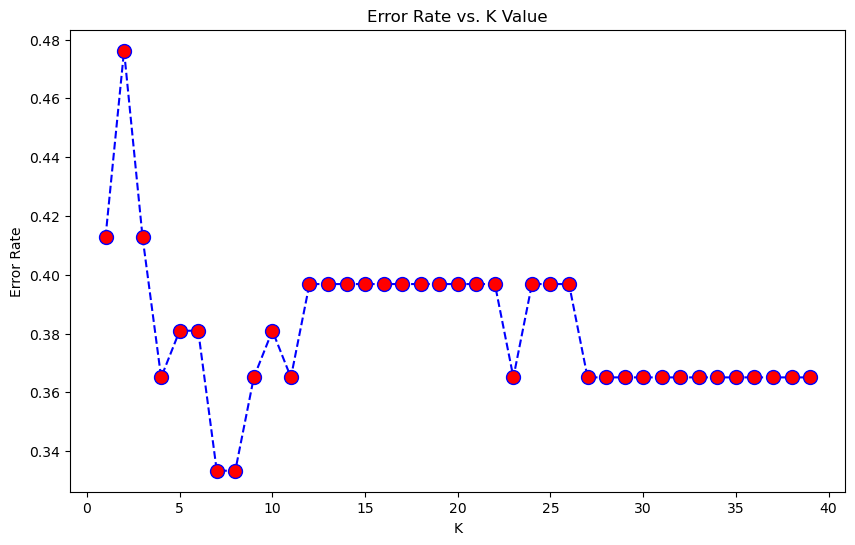

In [200]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [148]:
from sklearn.tree import DecisionTreeClassifier

In [149]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [150]:
dpred = dtree.predict(X_test)

In [151]:
print(classification_report(y_test,dpred))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81        26
           1       1.00      1.00      1.00        11
           2       0.77      0.92      0.84        26

    accuracy                           0.86        63
   macro avg       0.89      0.88      0.88        63
weighted avg       0.87      0.86      0.86        63



In [153]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       1.00      1.00      1.00        11
           2       0.93      0.96      0.94        26

    accuracy                           0.95        63
   macro avg       0.96      0.96      0.96        63
weighted avg       0.95      0.95      0.95        63



In [154]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train,y_train)
SVpred = model.predict(X_test)
print(classification_report(y_test,SVpred))

              precision    recall  f1-score   support

           0       0.61      0.42      0.50        26
           1       0.46      0.55      0.50        11
           2       0.72      0.88      0.79        26

    accuracy                           0.63        63
   macro avg       0.60      0.62      0.60        63
weighted avg       0.63      0.63      0.62        63



In [163]:
from sklearn.linear_model import RidgeClassifierCV
clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1])

In [164]:
clf.fit(X_train,y_train)

RidgeClassifierCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]))

In [165]:
clf.score(X_train, y_train)

0.903448275862069

In [167]:
clfpred = clf.predict(X_test)

In [168]:
print(classification_report(y_test,clfpred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        26
           1       0.83      0.91      0.87        11
           2       0.68      1.00      0.81        26

    accuracy                           0.78        63
   macro avg       0.84      0.80      0.78        63
weighted avg       0.84      0.78      0.76        63



In [172]:
 from sklearn.metrics import accuracy_score
from sklearn import metrics

In [170]:
accuracy_score(y_test, clfpred)

0.7777777777777778

In [173]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, clfpred, pos_label=2)

In [174]:
metrics.auc(fpr, tpr)

0.8378378378378378